In [3]:
!pip install kagglehub --quiet

import os
import zipfile
import kagglehub

# Download dataset
path = kagglehub.dataset_download("dansbecker/food-101")
zip_path = os.path.join(path, "food-101.zip")

# Extract the zip file properly
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working/")

# Find where meta and images actually are
FOOD101_PATH = None
for root, dirs, files in os.walk("/kaggle/working/"):
    if 'meta' in dirs and 'images' in dirs:
        FOOD101_PATH = root
        break

if FOOD101_PATH:
    META_PATH = os.path.join(FOOD101_PATH, 'meta')
    IMAGES_PATH = os.path.join(FOOD101_PATH, 'images')
    print(f"Dataset ready at: {FOOD101_PATH}")
else:
    print("Checking extracted contents:")
    print(os.listdir("/kaggle/working/"))
    if os.path.exists("/kaggle/working/food-101"):
        print("Contents of food-101:")
        print(os.listdir("/kaggle/working/food-101"))

Checking extracted contents:
['food-101.zip', '.virtual_documents']


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import vgg16,VGG19
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.src.layers.pooling.average_pooling2d import AvgPool2D
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

2025-08-16 08:31:25.877508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755333086.103894      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755333086.166549      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
print("Inpute Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101/food-101'))

print("\nMeta Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101/food-101/meta'))

Inpute Files Directory
['meta', 'README.txt', 'images', 'license_agreement.txt', '.DS_Store']

Meta Files Directory
['test.txt', 'train.json', 'labels.txt', 'test.json', 'train.txt', 'classes.txt']


In [6]:
print(os.listdir('/kaggle/input/food-101/food-101/food-101/images'))

['macarons', 'french_toast', 'lobster_bisque', 'prime_rib', 'pork_chop', 'guacamole', 'baby_back_ribs', 'mussels', 'beef_carpaccio', 'poutine', 'hot_and_sour_soup', 'seaweed_salad', 'foie_gras', 'dumplings', 'peking_duck', 'takoyaki', 'bibimbap', 'falafel', 'pulled_pork_sandwich', 'lobster_roll_sandwich', 'carrot_cake', 'beet_salad', 'panna_cotta', 'donuts', 'red_velvet_cake', 'grilled_cheese_sandwich', 'cannoli', 'spring_rolls', 'shrimp_and_grits', 'clam_chowder', 'omelette', 'fried_calamari', 'caprese_salad', 'oysters', 'scallops', 'ramen', 'grilled_salmon', 'croque_madame', 'filet_mignon', 'hamburger', 'spaghetti_carbonara', 'miso_soup', 'bread_pudding', 'lasagna', 'crab_cakes', 'cheesecake', 'spaghetti_bolognese', 'cup_cakes', 'creme_brulee', 'waffles', 'fish_and_chips', 'paella', 'macaroni_and_cheese', 'chocolate_mousse', 'ravioli', 'chicken_curry', 'caesar_salad', 'nachos', 'tiramisu', 'frozen_yogurt', 'ice_cream', 'risotto', 'club_sandwich', 'strawberry_shortcake', 'steak', 'chu

In [7]:
classes = ['macarons', 'french_toast', 'lobster_bisque', 'prime_rib', 'pork_chop', 'guacamole', 'baby_back_ribs', 
           'mussels', 'beef_carpaccio', 'poutine', 'hot_and_sour_soup', 'seaweed_salad', 'foie_gras', 'dumplings',
           'peking_duck', 'takoyaki', 'bibimbap', 'falafel', 'pulled_pork_sandwich', 'lobster_roll_sandwich',
           'carrot_cake', 'beet_salad', 'panna_cotta', 'donuts', 'red_velvet_cake', 'grilled_cheese_sandwich',
           'cannoli', 'spring_rolls', 'shrimp_and_grits', 'clam_chowder', 'omelette', 'fried_calamari', 
           'caprese_salad', 'oysters', 'scallops', 'ramen', 'grilled_salmon', 'croque_madame', 'filet_mignon',
           'hamburger', 'spaghetti_carbonara', 'miso_soup', 'bread_pudding', 'lasagna', 'crab_cakes', 'cheesecake',
           'spaghetti_bolognese', 'cup_cakes', 'creme_brulee', 'waffles', 'fish_and_chips', 'paella',
           'macaroni_and_cheese', 'chocolate_mousse', 'ravioli', 'chicken_curry', 'caesar_salad', 'nachos',
           'tiramisu', 'frozen_yogurt', 'ice_cream', 'risotto', 'club_sandwich', 'strawberry_shortcake', 'steak', 
           'churros', 'garlic_bread', 'baklava', 'bruschetta', 'hummus', 'chicken_wings', 'greek_salad', 
           'tuna_tartare', 'chocolate_cake', 'gyoza', 'eggs_benedict', 'deviled_eggs', 'samosa', 'sushi',
           'breakfast_burrito', 'ceviche', 'beef_tartare', 'apple_pie', '.DS_Store', 'huevos_rancheros', 'beignets', 
           'pizza', 'edamame', 'french_onion_soup', 'hot_dog', 'tacos', 'chicken_quesadilla', 'pho', 'gnocchi', 
           'pancakes', 'fried_rice', 'cheese_plate', 'onion_rings', 'escargots', 'sashimi', 'pad_thai', 'french_fries']
classes.sort()
print(len(classes))
classes
classes = classes[1:]
print(len(classes))
classes

102
101


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
s = """Apple Pie: ~2.5 calories per gram
Baby Back Ribs: ~3.5 calories per gram
Baklava: ~5 calories per gram
Beef Carpaccio: ~2 calories per gram
Beef Tartare: ~2.5 calories per gram
Beet Salad: ~0.5 calories per gram
Beignets: ~3.5 calories per gram
Bibimbap: ~1.5 calories per gram
Bread Pudding: ~2.5 calories per gram
Breakfast Burrito: ~2 calories per gram
Bruschetta: ~1 calorie per gram
Caesar Salad: ~0.5 calories per gram
Cannoli: ~3.5 calories per gram
Caprese Salad: ~1 calorie per gram
Carrot Cake: ~3.5 calories per gram
Ceviche: ~0.5 calories per gram
Cheese Plate: ~3.5 calories per gram
Cheesecake: ~3.5 calories per gram
Chicken Curry: ~1.5 calories per gram
Chicken Quesadilla: ~2.5 calories per gram
Chicken Wings: ~3 calories per gram
Chocolate Cake: ~4 calories per gram
Chocolate Mousse: ~3 calories per gram
Churros: ~4 calories per gram
Clam Chowder: ~1.5 calories per gram
Club Sandwich: ~2.5 calories per gram
Crab Cakes: ~2 calories per gram
Creme Brulee: ~3.5 calories per gram
Croque Madame: ~3 calories per gram
Cupcakes: ~3.5 calories per gram
Deviled Eggs: ~1 calorie per gram
Donuts: ~4 calories per gram
Dumplings: ~2.5 calories per gram
Edamame: ~1 calorie per gram
Eggs Benedict: ~2.5 calories per gram
Escargots: ~1 calorie per gram
Falafel: ~2 calories per gram
Filet Mignon: ~2.5 calories per gram
Fish and Chips: ~2.5 calories per gram
Foie Gras: ~4.5 calories per gram
French Fries: ~3.5 calories per gram
French Onion Soup: ~1 calorie per gram
French Toast: ~2 calories per gram
Fried Calamari: ~2.5 calories per gram
Fried Rice: ~1.5 calories per gram
Frozen Yogurt: ~1 calorie per gram
Garlic Bread: ~4 calories per gram
Gnocchi: ~1.5 calories per gram
Greek Salad: ~0.5 calories per gram
Grilled Cheese Sandwich: ~3 calories per gram
Grilled Salmon: ~2 calories per gram
Guacamole: ~2 calories per gram
Gyoza: ~2 calories per gram
Hamburger: ~3.5 calories per gram
Hot and Sour Soup: ~0.5 calories per gram
Hot Dog: ~3.5 calories per gram
Huevos Rancheros: ~2 calories per gram
Hummus: ~1.5 calories per gram
Ice Cream: ~2 calories per gram
Lasagna: ~1.5 calories per gram
Lobster Bisque: ~1 calorie per gram
Lobster Roll Sandwich: ~2.5 calories per gram
Macaroni and Cheese: ~3 calories per gram
Macarons: ~4 calories per gram
Miso Soup: ~0.5 calories per gram
Mussels: ~0.5 calories per gram
Nachos: ~2.5 calories per gram
Omelette: ~1.5 calories per gram
Onion Rings: ~2.5 calories per gram
Oysters: ~0.5 calories per gram
Pad Thai: ~2 calories per gram
Paella: ~1.5 calories per gram
Pancakes: ~2 calories per gram
Panna Cotta: ~3.5 calories per gram
Peking Duck: ~4 calories per gram
Pho: ~1 calorie per gram
Pizza: ~2.5 calories per gram
Pork Chop: ~2.5 calories per gram
Poutine: ~2.5 calories per gram
Prime Rib: ~2.5 calories per gram
Pulled Pork Sandwich: ~2.5 calories per gram
Ramen: ~1 calorie per gram
Ravioli: ~1.5 calories per gram
Red Velvet Cake: ~4 calories per gram
Risotto: ~1.5 calories per gram
Samosa: ~2 calories per gram
Sashimi: ~1 calorie per gram
Scallops: ~1 calorie per gram
Seaweed Salad: ~0.5 calories per gram
Shrimp and Grits: ~2 calories per gram
Spaghetti Bolognese: ~1.5 calories per gram
Spaghetti Carbonara: ~2 calories per gram
Spring Rolls: ~1.5 calories per gram
Steak: ~2.5 calories per gram
Strawberry Shortcake: ~3.5 calories per gram
Sushi: ~1 calorie per gram
Tacos: ~2 calories per gram
Takoyaki: ~2.5 calories per gram
Tiramisu: ~3 calories per gram
Tuna Tartare: ~1.5 calories per gram
Waffles: ~2 calories per gram
"""
calories = s.splitlines()
calories

['Apple Pie: ~2.5 calories per gram',
 'Baby Back Ribs: ~3.5 calories per gram',
 'Baklava: ~5 calories per gram',
 'Beef Carpaccio: ~2 calories per gram',
 'Beef Tartare: ~2.5 calories per gram',
 'Beet Salad: ~0.5 calories per gram',
 'Beignets: ~3.5 calories per gram',
 'Bibimbap: ~1.5 calories per gram',
 'Bread Pudding: ~2.5 calories per gram',
 'Breakfast Burrito: ~2 calories per gram',
 'Bruschetta: ~1 calorie per gram',
 'Caesar Salad: ~0.5 calories per gram',
 'Cannoli: ~3.5 calories per gram',
 'Caprese Salad: ~1 calorie per gram',
 'Carrot Cake: ~3.5 calories per gram',
 'Ceviche: ~0.5 calories per gram',
 'Cheese Plate: ~3.5 calories per gram',
 'Cheesecake: ~3.5 calories per gram',
 'Chicken Curry: ~1.5 calories per gram',
 'Chicken Quesadilla: ~2.5 calories per gram',
 'Chicken Wings: ~3 calories per gram',
 'Chocolate Cake: ~4 calories per gram',
 'Chocolate Mousse: ~3 calories per gram',
 'Churros: ~4 calories per gram',
 'Clam Chowder: ~1.5 calories per gram',
 'Club S

In [9]:
# img = cv2.imread('/kaggle/input/food-101/food-101/food-101/images/apple_pie/100.jpeg')
# print(img.shape)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.1)

train_data = train_datagen.flow_from_directory('/kaggle/input/food-101/food-101/food-101/images/',
                                              target_size = (224,224),
                                              batch_size=100,
                                              class_mode='categorical',
                                              shuffle=True,
                                              subset='training')

test_data = train_datagen.flow_from_directory('/kaggle/input/food-101/food-101/food-101/images/',
                                               target_size=(224,224),
                                               batch_size=100,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

Found 90900 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [11]:
train_data.image_shape

(224, 224, 3)

In [12]:
print(np.unique(train_data.labels))
train_data.class_indices

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

In [13]:
new_input = Input(shape=(224,224,3))
base_model = DenseNet201(weights = 'imagenet',
                        include_top = False,
                        input_tensor = new_input)

I0000 00:00:1755333212.421096      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
for layer in base_model.layers[:]:
  layer.trainable = False

In [15]:
model_dn = Sequential()
model_dn.add(base_model)
model_dn.add(Flatten())
model_dn.add(Dense(1000, activation='relu'))
model_dn.add(Dense(1000, activation='relu'))
model_dn.add(Dense(101, activation='softmax'))
model_dn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 94080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    94,081,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 101)            │       101,101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,505,085 (432.99 MB)

 Trainable params: 95,183,101 (363.09 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [16]:
model_dn.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

results_dn = model_dn.fit(train_data, epochs=15, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks = EarlyStopping(patience=5, monitor='val_accuracy',restore_best_weights=True)
                  )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1755333252.605794     127 service.cc:148] XLA service 0x7b5970033a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755333252.606966     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755333257.317483     127 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755333281.101014     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


909/909 ━━━━━━━━━━━━━━━━━━━━ 1174s 1s/step - accuracy: 0.3010 - loss: 6.7872 - val_accuracy: 0.4954 - val_loss: 2.0015
Epoch 2/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 437s 481ms/step - accuracy: 0.5653 - loss: 1.6515 - val_accuracy: 0.5214 - val_loss: 1.8716
Epoch 3/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 393s 432ms/step - accuracy: 0.6331 - loss: 1.3536 - val_accuracy: 0.5244 - val_loss: 1.9260
Epoch 4/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 398s 437ms/step - accuracy: 0.6726 - loss: 1.1812 - val_accuracy: 0.5117 - val_loss: 2.0146
Epoch 5/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 392s 431ms/step - accuracy: 0.7052 - loss: 1.0488 - val_accuracy: 0.5190 - val_loss: 2.0727
Epoch 6/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 393s 432ms/step - accuracy: 0.7312 - loss: 0.9384 - val_accuracy: 0.5185 - val_loss: 2.2507
Epoch 7/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 381s 419ms/step - accuracy: 0.7571 - loss: 0.8409 - val_accuracy: 0.4974 - val_loss: 2.5026
Epoch 8/15
909/909 ━━━━━━━━━━━━━━━━━━━━ 367s 403ms/step - accuracy: 0.7745 - loss: 0.7684

In [17]:
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(4096, activation='relu'))
model_vgg.add(Dense(4096, activation='relu'))
model_vgg.add(Dropout(0.25))
model_vgg.add(Dense(101, activation='softmax'))
model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 101)            │       413,797 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,984,037 (534.00 MB)

 Trainable params: 119,959,653 (457.61 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [20]:
model_vgg.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

results_vgg = model_vgg.fit(train_data, epochs=5, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks = EarlyStopping(patience=5, monitor='val_accuracy',restore_best_weights=True)
                  )

Epoch 1/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 415s 430ms/step - accuracy: 0.0936 - loss: 4.8187 - val_accuracy: 0.2131 - val_loss: 3.2203
Epoch 2/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 398s 437ms/step - accuracy: 0.2325 - loss: 3.0954 - val_accuracy: 0.2289 - val_loss: 3.1314
Epoch 3/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 381s 419ms/step - accuracy: 0.2711 - loss: 2.9031 - val_accuracy: 0.2456 - val_loss: 3.0927
Epoch 4/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 384s 423ms/step - accuracy: 0.2949 - loss: 2.7715 - val_accuracy: 0.2424 - val_loss: 3.1005
Epoch 5/5
909/909 ━━━━━━━━━━━━━━━━━━━━ 383s 421ms/step - accuracy: 0.3139 - loss: 2.6732 - val_accuracy: 0.2471 - val_loss: 3.1048


In [21]:
from keras.applications import InceptionV3
from keras.layers import Input, AveragePooling2D, Dropout, Flatten, Dense
from keras.models import Model
from keras.regularizers import l2

# Assuming other parts of your code remain unchanged

inception = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

x = inception.output
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(101, kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.0005), activation='softmax')(x)

model_incep = Model(inputs=inception.input, outputs=x)
model_incep.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,630,277 (86.33 MB)

 Trainable params: 22,595,845 (86.20 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [22]:
from keras.optimizers import SGD

opt = SGD(learning_rate=0.1, momentum=0.9)
model_incep.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
result_incep = model_incep.fit(train_data,epochs=10,validation_data=test_data,steps_per_epoch=len(train_data),validation_steps=len(test_data),callbacks=[EarlyStopping(patience=5,monitor='val_accuracy',restore_best_weights=True)])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_765']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-08-16 10:13:04.917091: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[192,80,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,80,54,54]{3,2,1,0}, f32[100,192,52,52]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-16 10:13:05.353503: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.436553104s
Trying algorithm eng0{} for conv (f32[192,80,3,3]{3,2

909/909 ━━━━━━━━━━━━━━━━━━━━ 462s 426ms/step - accuracy: 0.0108 - loss: 4.9021 - val_accuracy: 0.0233 - val_loss: 4.5684
Epoch 2/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 383s 421ms/step - accuracy: 0.0352 - loss: 4.4722 - val_accuracy: 0.0505 - val_loss: 4.4858
Epoch 3/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 401s 441ms/step - accuracy: 0.0778 - loss: 4.1112 - val_accuracy: 0.0725 - val_loss: 4.2483
Epoch 4/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 388s 427ms/step - accuracy: 0.1416 - loss: 3.7714 - val_accuracy: 0.1417 - val_loss: 3.9090
Epoch 5/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 383s 421ms/step - accuracy: 0.2109 - loss: 3.4341 - val_accuracy: 0.2202 - val_loss: 3.4914
Epoch 6/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 371s 408ms/step - accuracy: 0.2911 - loss: 3.0714 - val_accuracy: 0.0202 - val_loss: 6.2324
Epoch 7/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 373s 410ms/step - accuracy: 0.3470 - loss: 2.8227 - val_accuracy: 0.1864 - val_loss: 4.1874
Epoch 8/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 364s 400ms/step - accuracy: 0.4290 - loss: 2.49

DenseNet201 is best option by observing comparisons

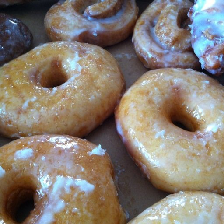

In [24]:
donuts = load_img("/kaggle/input/food-101/food-101/food-101/images/donuts/2563686.jpg",target_size=(224,224,3))
donuts

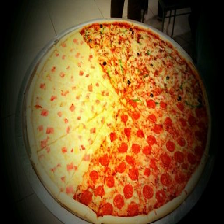

In [25]:
pizza = load_img("/kaggle/input/food-101/food-101/food-101/images/pizza/768276.jpg",target_size=(224,224,3))
pizza

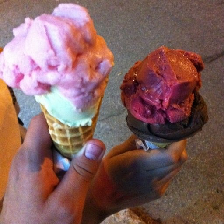

In [26]:
ice_cream = load_img("/kaggle/input/food-101/food-101/food-101/images/ice_cream/579407.jpg",target_size=(224,224))
ice_cream

In [27]:
donuts = img_to_array(donuts)
pizza = img_to_array(pizza)
ice_cream = img_to_array(ice_cream)

donuts = donuts/255
pizza = pizza/255
ice_cream = ice_cream/255


donuts = donuts.reshape(1,224,224,3)
pizza = pizza.reshape(1,224,224,3)
ice_cream = ice_cream.reshape(1,224,224,3)

In [28]:
p1 = (model_dn.predict(donuts)).argmax()

print("Class ",p1,": ",classes[p1],sep='')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
Class 31: donuts


In [29]:
p2 = (model_dn.predict(pizza)).argmax()

print("Class ",p2,": ",classes[p2],sep='')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Class 83: red_velvet_cake


In [30]:
p3 = (model_dn.predict(ice_cream)).argmax()

print("Class ",p3,": ",classes[p3],sep='')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Class 58: ice_cream
